In [2]:
import pandas as pd
import numpy as np
from numpy import diff

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl

# import geopandas as gpd
import math

from matplotlib.patches import Circle, Wedge, Polygon

import os
import matplotlib.patheffects as path_effects


from netCDF4 import Dataset as NetCDFFile 

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm

from obspy.core import UTCDateTime

from datetime import datetime, timezone

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})


# set the font globally
# plt.rcParams.update({'font.family':'Helvetica'})

In [3]:
# data = pd.read_csv('sum_with_2005_eqs.csv', header = 'infer')
data = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/SUeq_data.csv", header = 'infer')
# data.dtypes

In [5]:
# slab
slab_length = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/depth_at_prof_50.csv", sep = ',', header = 'infer')
slab_length=slab_length.append(slab_length, ignore_index=True)
slab_length = slab_length.sort_values(by = 'ALONG',ascending=True)
length = np.asarray(slab_length['LENGTH'])

In [3]:
data = data[(data['MW'] >= 5.1)]

data.sort_values(by = 'MW', ascending = False, inplace = True)

data['DATE'] = pd.to_datetime(data['DATE']) # change dtype to datetime format
data['DATE'] = data['DATE'].dt.strftime('%Y-%m-%d') # change dtype to object

# data['DATE'] and data['TIME'] should be object (str) to perform + operator

data_dummy = np.array(data['DATE'] + ' ' + data['TIME'])

data_ev_time = []

for val in data_dummy:
    data_ev_time.append(UTCDateTime(val))

    
ref_date = data_ev_time[0]

data_ev_time = np.array(data_ev_time)

date = []

for val in data_ev_time:
    date.append(val - ref_date)
    
date = np.array(date) # this is in seconds

data['YEARS'] = date/31536000

data = data.sort_values(by ='YEARS', ascending=True) # this is an important step
data = data[(data['YEARS'] >= -25)]

In [4]:
########## Cumulative moment relase for Sumatra-Andaman MegaThrust (< 70 km)
data_mt = data.loc[data['CLASS'] == 'MTHRUST']
data_mt = data_mt[(data_mt['LAT'] <= 6) & (data_mt['LAT'] >= -6) &
                 (data_mt['DEPTH'] < 70) & (data_mt['MW'] >= 5.1)]

mt_exp = np.asarray(data_mt['EX'])
mt_mo = np.asarray(data_mt['MO'])
mt_time = np.asarray(data_mt['YEARS'])
mt_energy = mt_mo*np.power(10., mt_exp)
mt_energy_cum = np.cumsum(mt_energy)
norm_mt_energy_cum = (mt_energy_cum - min(mt_energy_cum)) / (max(mt_energy_cum) - min(mt_energy_cum))

# mt_strain = np.sqrt(mt_energy)
# mt_strain_cum = np.cumsum(mt_strain)

In [5]:
########## Cumulative moment relase for shallow Sumatra-Andaman slab (< 70 km)
data_sumslab_shallow = data.loc[data['CLASS'] == 'DGOING']
data_sumslab_shallow = data_sumslab_shallow[(data_sumslab_shallow['LAT'] <= 14) & (data_sumslab_shallow['LAT'] >= -2.5) &
                 (data_sumslab_shallow['DEPTH'] < 70) &
                            (data_sumslab_shallow['MW'] >= 5.1)]

sumslab_shallow_exp = np.asarray(data_sumslab_shallow['EX'])
sumslab_shallow_mo = np.asarray(data_sumslab_shallow['MO'])
sumslab_shallow_time = np.asarray(data_sumslab_shallow['YEARS'])
sumslab_shallow_energy = sumslab_shallow_mo*np.power(10., sumslab_shallow_exp)
sumslab_shallow_energy_cum = np.cumsum(sumslab_shallow_energy)
norm_sumslab_shallow_energy_cum = (sumslab_shallow_energy_cum - min(sumslab_shallow_energy_cum)) / (max(sumslab_shallow_energy_cum) - min(sumslab_shallow_energy_cum))

In [6]:
########## Cumulative moment relase for intermediate Sumatra-Andaman slab (70-300 km)
data_sumslab_intermediate = data.loc[data['CLASS'] == 'DGOING']
data_sumslab_intermediate = data_sumslab_intermediate[(data_sumslab_intermediate['LAT'] <= 14) & (data_sumslab_intermediate['LAT'] >= -2.5) &
                 (data_sumslab_intermediate['DEPTH'] > 70) & (data_sumslab_intermediate['DEPTH'] < 300) &
                            (data_sumslab_intermediate['MW'] >= 5.1)]

sumslab_intermediate_exp = np.asarray(data_sumslab_intermediate['EX'])
sumslab_intermediate_mo = np.asarray(data_sumslab_intermediate['MO'])
sumslab_intermediate_time = np.asarray(data_sumslab_intermediate['YEARS'])
sumslab_intermediate_energy = sumslab_intermediate_mo*np.power(10., sumslab_intermediate_exp)
sumslab_intermediate_energy_cum = np.cumsum(sumslab_intermediate_energy)
norm_sumslab_intermediate_energy_cum = (sumslab_intermediate_energy_cum - min(sumslab_intermediate_energy_cum)) / (max(sumslab_intermediate_energy_cum) - min(sumslab_intermediate_energy_cum))

In [7]:
########## Cumulative moment relase for intermediate long slab (70-300 km)
data_javaslab_intermediate = data.loc[data['CLASS'] == 'DGOING']
data_javaslab_intermediate = data_javaslab_intermediate[(data_javaslab_intermediate['LAT'] < -2.5) &
                 (data_javaslab_intermediate['DEPTH'] > 70) &  (data_javaslab_intermediate['DEPTH'] < 300) &
                              (data_javaslab_intermediate['MW'] >= 5.1)]

javaslab_intermediate_exp = np.asarray(data_javaslab_intermediate['EX'])
javaslab_intermediate_mo = np.asarray(data_javaslab_intermediate['MO'])
javaslab_intermediate_time = np.asarray(data_javaslab_intermediate['YEARS'])
javaslab_intermediate_energy = javaslab_intermediate_mo*np.power(10., javaslab_intermediate_exp)
javaslab_intermediate_energy_cum = np.cumsum(javaslab_intermediate_energy)
norm_javaslab_intermediate_energy_cum = (javaslab_intermediate_energy_cum - min(javaslab_intermediate_energy_cum)) / (max(javaslab_intermediate_energy_cum) - min(javaslab_intermediate_energy_cum))

In [8]:
########## Cumulative moment relase for deep long slab (> 300 km)
data_javaslab_deep = data.loc[data['CLASS'] == 'DGOING']
data_javaslab_deep = data_javaslab_deep[(data_javaslab_deep['LAT'] < -2.5) &
                 (data_javaslab_deep['DEPTH'] > 70) &
                              (data_javaslab_deep['MW'] >= 5.1)]

javaslab_deep_exp = np.asarray(data_javaslab_deep['EX'])
javaslab_deep_mo = np.asarray(data_javaslab_deep['MO'])
javaslab_deep_time = np.asarray(data_javaslab_deep['YEARS'])
javaslab_deep_energy = javaslab_deep_mo*np.power(10., javaslab_deep_exp)
javaslab_deep_energy_cum = np.cumsum(javaslab_deep_energy)
norm_javaslab_deep_energy_cum = (javaslab_deep_energy_cum - min(javaslab_deep_energy_cum)) / (max(javaslab_deep_energy_cum) - min(javaslab_deep_energy_cum))

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: MatplotlibDeprecationWarning: Saw kw

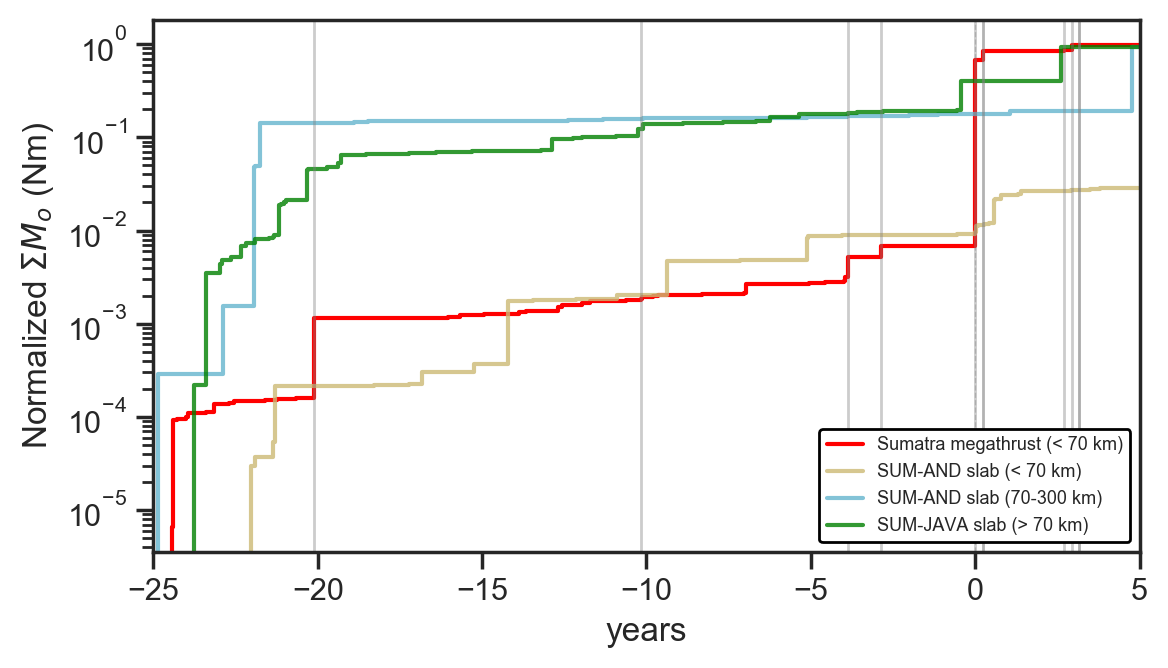

In [13]:
figsize = (6,3.5)
dpi=200
width = 1
# xlimit = [-4, 4]
# ylimit = [0e18, 3e18]

fig, ax = plt.subplots(1, dpi=dpi, figsize = figsize, sharex= False)

fig1=ax

lw = 10
alpha=0.4
color_mt = 'red'
color_SUM_AND_shallow = 'y'
color_SUM_AND_intermediate = 'c'
color_SUM_Java_intermediate = 'magenta'
color_SUM_Java_deep = 'green'
fig1.axvline(x=0, color='grey', lw=0.5, ls='--', alpha=alpha)

###### Sumatra-Andaman megathrust
new_t = []
for i, s in enumerate(mt_time):
    new_t.append(s)
    if i != 0:
        new_t.append(s)
    
# the y value
new_y = []
for i, s in enumerate(norm_mt_energy_cum):
    if i != 0:
        new_y.append(norm_mt_energy_cum[i-1])
        new_y.append(s)
    else:
        new_y.append(s)

fig1.plot(new_t, new_y, '-', markersize = 5,
          linewidth=1.5, color = color_mt,
          alpha=1, label='Sumatra megathrust (< 70 km)',
         mfc = 'white',mew = 1, lw = 1)

###### Sumatra-andaman shallow slab plot
new_t = []
for i, s in enumerate(sumslab_shallow_time):
    new_t.append(s)
    if i != 0:
        new_t.append(s)
    
# the y value
new_y = []
for i, s in enumerate(norm_sumslab_shallow_energy_cum):
    if i != 0:
        new_y.append(norm_sumslab_shallow_energy_cum[i-1])
        new_y.append(s)
    else:
        new_y.append(s)

fig1.plot(new_t, new_y, '-', markersize = 5,
          linewidth=1.5, color = color_SUM_AND_shallow,
          alpha=0.8, label='SUM-AND slab (< 70 km)',
          mfc = 'white',mew = 1, lw = 1)

###### Sumatra-andaman intermediate slab plot
new_t = []
for i, s in enumerate(sumslab_intermediate_time):
    new_t.append(s)
    if i != 0:
        new_t.append(s)
    
# the y value
new_y = []
for i, s in enumerate(norm_sumslab_intermediate_energy_cum):
    if i != 0:
        new_y.append(norm_sumslab_intermediate_energy_cum[i-1])
        new_y.append(s)
    else:
        new_y.append(s)

fig1.plot(new_t, new_y, '-', markersize = 5,
          linewidth=1.5, color = color_SUM_AND_intermediate,
          alpha=0.8, label='SUM-AND slab (70-300 km)',
          mfc = 'white',mew = 1, lw = 1)


###### Sumatra-Java intermediate slab plot
# new_t = []
# for i, s in enumerate(javaslab_intermediate_time):
#     new_t.append(s)
#     if i != 0:
#         new_t.append(s)
    
# # the y value
# new_y = []
# for i, s in enumerate(javaslab_intermediate_energy_cum):
#     if i != 0:
#         new_y.append(javaslab_intermediate_energy_cum[i-1])
#         new_y.append(s)
#     else:
#         new_y.append(s)

# fig1.plot(new_t, new_y, '-', markersize = 5,
#           linewidth=1.5, color = color_SUM_Java_intermediate,
#           alpha=0.8, label='SUM-JAVA slab (70-300 km)',
#           mfc = 'white',mew = 1, lw = 1)



##### Sumatra-Java deep slab plot
new_t = []
for i, s in enumerate(javaslab_deep_time):
    new_t.append(s)
    if i != 0:
        new_t.append(s)
    
# the y value
new_y = []
for i, s in enumerate(norm_javaslab_deep_energy_cum):
    if i != 0:
        new_y.append(norm_javaslab_deep_energy_cum[i-1])
        new_y.append(s)
    else:
        new_y.append(s)

fig1.plot(new_t, new_y, '-', markersize = 5,
          linewidth=1.5, color = color_SUM_Java_deep,
          alpha=0.8, label='SUM-JAVA slab (> 70 km)',
          mfc = 'white',mew = 1, lw = 1)




# #####
fig1.set_xlim([-25, 5])
# fig1.set_ylim([1e17, 1e24])

fig1.set_yscale('log')

fig1.set_xlabel('years')
fig1.set_ylabel(r'Normalized $\Sigma M_o$ (Nm)')

fig1.legend(loc = 'lower right',
            fontsize = 6.5,
            facecolor="white",
            framealpha=1,
            edgecolor="black",
            markerscale=0.9)

##### events Mw ≥ 7.0
color='grey'
lw=1
fig1.axvline(x=-20.12, color=color, lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=-10.16, color=color, lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=-3.868836, color=color, lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=-2.87, color=color, lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=0, color=color, lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=0.25, color=color, lw=lw, ls='-', alpha=0.6)
fig1.axvline(x=2.71, color=color, lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=2.95, color=color, lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=3.15, color=color, lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=3.16, color=color, lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=5.44, color='grey', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=5.69, color='grey', lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=5.83, color='grey', lw=lw, ls='-', alpha=alpha)

# fs = 8
# fig1.annotate('$M_w9.0$ (2004)', color='black',
#               xy=(-0.05, 2e21),
#               xytext=(-10, 0.2e22), fontsize=fs,
#             arrowprops=dict(facecolor='black',
#                             shrink=0.05, headwidth=5, width=0.1, edgecolor='black'))
# bbox=dict(boxstyle="round", fc="none", ec="gray")

# fig1.annotate('$M_w8.5$ (2005)', color='black',
#               xy=(0.35, 4.3e22),
#               xytext=(-10, 0.99e22), fontsize=fs,
#             arrowprops=dict(facecolor='black',
#                             shrink=0.05, headwidth=5, width=0.1, edgecolor='black'))
# bbox=dict(boxstyle="round", fc="none", ec="gray")


# fig1.annotate('$M_w8.5$ (2007)', color='black',
#               xy=(2.9, 4.5e22),
#               xytext=(3.5, 0.5e22), fontsize=fs,
#             arrowprops=dict(facecolor='black',
#                             shrink=0.05, headwidth=5, width=0.1, edgecolor='black'))
# bbox=dict(boxstyle="round", fc="none", ec="gray")


plt.tight_layout()

plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/EMo_years.png"
            , dpi = 500, transparent= True, bbox_inches='tight')

In [10]:
data = data[(data['DEPTH'] < 50) &
           (data['LAT'] >= -6) & (data['LAT'] <= 6) &
        (data['MW'] >= 7) &
           (data['CLASS'] == 'MTHRUST') &
          (data['YEARS'] <= 5)]

print(data[['LAT','DEPTH', 'YEARS', 'MW', 'DATE', 'CLASS']])

        LAT  DEPTH      YEARS   MW        DATE    CLASS
1361  0.173   28.1 -20.120661  7.1  1984-11-17  MTHRUST
2054 -4.837   34.0  -3.868836  7.3  2001-02-13  MTHRUST
1758  2.837   28.9  -2.874320  7.2  2002-02-11  MTHRUST
1426  3.299   28.6   0.000000  9.0  2004-12-26  MTHRUST
2625  3.026   25.8   0.252502  8.6  2005-03-28  MTHRUST
939  -2.174   20.0   2.714922  7.0  2007-09-13  MTHRUST
2169 -4.458   32.0   2.953983  8.5  2007-12-09  MTHRUST
1757  2.742   32.0   3.153756  7.3  2008-02-20  MTHRUST
648  -2.491   30.9   3.166891  7.2  2008-02-25  MTHRUST


# Cumulative number of events VS time

In [11]:
count_mt = data_mt["YEARS"]
# norm_count_mt = (count_mt - min(count_mt)) / (max(count_mt) - min(count_mt))

count_sumslab_shallow = data_sumslab_shallow["YEARS"]
# norm_sumslab_shallow = (count_sumslab_shallow - min(count_sumslab_shallow)) / (max(count_sumslab_shallow) - min(count_sumslab_shallow))

count_sumslab_intermediate = data_sumslab_intermediate ["YEARS"]
# norm_sumslab_intermediate = (count_sumslab_intermediate - min(count_sumslab_intermediate)) / (max(count_sumslab_intermediate) - min(count_sumslab_intermediate))

count_javaslab_deep = data_javaslab_deep["YEARS"]
# norm_javaslab_deep = (count_javaslab_deep - min(count_javaslab_deep)) / (max(count_javaslab_deep) - min(count_javaslab_deep))


In [ ]:
# count_and = data_AND["YEARS"]

# num_event_mt = len(count_mt) 
# print('Total number of megathrust events in 2004-2005 rupture zone:', num_event_mt)

# num_event_java = len(count_javaslab) 
# print('Total number of events in Java:', num_event_java)

# num_event_sum = len(count_sumslab) 
# print('Total number of events in Sumatra:', num_event_sum)

# # num_event_and = len(count_and)
# # print('Total number of events in Andaman:', num_event_and)

In [ ]:
# figsize = (6,2)
# dpi=200
lw=1.5
bins=300
alpha=0.7

fig, ax = plt.subplots(1, dpi=dpi, figsize = figsize, sharex= True)
fig=ax

# normalised number of events

fig.hist(count_mt,  bins=bins,  histtype='step', cumulative=True, color=color_mt, linewidth=1.5, label='SUM-AND megathrust (< 70 km)')
fig.hist(count_sumslab_shallow,  bins=bins,  histtype='step', cumulative=True, color=color_SUM_AND_shallow, linewidth=1.5, label='SUM-AND slab (70-300 km)')
fig.hist(count_sumslab_intermediate,  bins=bins,  histtype='step', cumulative=True, color=color_SUM_AND_intermediate, linewidth=1.5, label='SUM-AND slab (70-300 km)')
# fig.hist(count_javaslab_intermediate,  bins=bins,  histtype='step', cumulative=True, color=color_SUM_Java_intermediate, linewidth=1.5, label='SUM-JAVA slab (70-300 km)')
# fig.hist(count_javaslab_deep,  bins=bins,  histtype='step', cumulative=True, color=color_SUM_Java_deep, linewidth=1.5, label='SUM-JAVA slab (> 300 km)')

# fig.hist(count_mt,  bins=bins,  histtype='step', color=color_mt, linewidth=1.5, label='SUM-AND megathrust (< 70 km)')
# fig.hist(count_sumslab_shallow,  bins=bins,  histtype='step', color=color_SUM_AND_shallow, linewidth=1.5, label='SUM-AND slab (70-300 km)')
# fig.hist(count_sumslab_intermediate,  bins=bins,  histtype='step', color=color_SUM_AND_intermediate, linewidth=1.5, label='SUM-AND slab (70-300 km)')
# # fig.hist(count_javaslab_intermediate,  bins=bins,  histtype='step', ccolor=color_SUM_Java_intermediate, linewidth=1.5, label='SUM-JAVA slab (70-300 km)')
# fig.hist(count_javaslab_deep,  bins=bins,  histtype='step', color=color_SUM_Java_deep, linewidth=1.5, label='SUM-JAVA slab (> 300 km)')


fig.set_ylabel('Cumulative Number of Events')
fig.set_xlabel('years')

fig.set_xlim([-25, 5])
# fig.set_xlim([-5, 5])

fig.set_yscale('log')

# fig.legend(loc = 'upper left',
#             fontsize = 6,
#             framealpha=1,
#            facecolor='white',
#             edgecolor="grey",
#             markerscale=0.1)

##### events Mw ≥ 7.0
color='grey'
lw=1
fig.axvline(x=-20.12, color=color, lw=lw, ls='-', alpha=alpha)
# fig1.axvline(x=-3.86, color='maroon', lw=lw, ls='-', alpha=alpha)
fig.axvline(x=-10.16, color=color, lw=lw, ls='-', alpha=alpha)
fig.axvline(x=-2.87, color=color, lw=lw, ls='-', alpha=alpha)
fig.axvline(x=0, color=color, lw=lw, ls='-', alpha=alpha)
fig.axvline(x=0.25, color=color, lw=lw, ls='-', alpha=0.6)
fig.axvline(x=2.71, color=color, lw=lw, ls='-', alpha=alpha)
fig.axvline(x=2.95, color=color, lw=lw, ls='-', alpha=alpha)
fig.axvline(x=3.15, color=color, lw=lw, ls='-', alpha=alpha)
fig.axvline(x=3.16, color=color, lw=lw, ls='-', alpha=alpha)

# fig.axvline(x=0.25, color='blue', lw=lw, ls='--', alpha=alpha) # 2005 event

# plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/CUMevents_years.png"
#             , dpi = 500, transparent= True, bbox_inches='tight')

## Check relation with background seismicity

In [ ]:
## load declustered data

data = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/stat-seismo-main/data/sum_20_all_nnd.h5")
# data = data[(data['magnitude'] >= 4.8)]
data.sort_values(by = 'magnitude', ascending = False, inplace = True)

data["second"] = data["seconde"]
data["date"] = pd.to_datetime(data[["year", "month", "day", "hour", "minute", "second"]]) # change dtype to datetime format

In [ ]:
## select reference date, i.e. 2004 mainshock
selected_value = UTCDateTime(data["date"].loc[1513]) # or replace this with any value you want as a reference point
years_passed = []

for idx, row in data["date"].iteritems():
    years_passed.append(UTCDateTime(row) - selected_value)

years_passed = np.array(years_passed)/31536000

data["YEARS"] = years_passed
data = data.sort_values(by = "YEARS", ascending = True)
data["Days"] = data['YEARS']*365

In [ ]:
# change the reference from the center of the earth to the surface of the earth
data['depth'] = 6371- data['depth']

In [ ]:
data = data[(data['latitude'] > -2.5) & (data['latitude'] < 14) &
           (data['magnitude'] >= 5.1) & (data['YEARS'] > -25)]

# data = data[(data['latitude'] < -2.5) &
#            (data['magnitude'] >= 5.1) & (data['YEARS'] > -25)]

In [ ]:
thresh = 10**-3.5 # to differentiate background seismicity and aftershocks

depth = 70
bins = 200

# select clustered seismicity by apply threshold
data_clustered = data[(data["Nij"] < thresh) &
                 (data['depth'] < depth)]

# select background seismicity by apply threshold
data_background = data[(data["Nij"] > thresh) &
                 (data['depth'] < depth)]

In [ ]:
count_clustered_shallow = data_clustered["YEARS"]
count_background_shallow = data_background["YEARS"]

In [ ]:
# figsize = (6,2)
# dpi=200
lw=1
bins=300
alpha=0.7

label1 = 'Clustered seismicity'
label2 = 'Background seismcity'

fig, ax = plt.subplots(1, dpi=dpi, figsize = figsize, sharex= True)
fig=ax

### normalised number of events
fig.hist(count_clustered_shallow,  bins=bins,  histtype='step', color='magenta', linewidth=0.5, label=label1)
# fig.hist(count_mt,  bins=bins,  histtype='step', color=color_mt, linewidth=0.5, label='SUM-AND megathrust')
fig.hist(count_background_shallow,  bins=bins,  histtype='step', color='orange', linewidth=0.5, label=label2)

fig.set_xlim([-25, 10])
# fig.set_ylim([0, 100])

fig.set_ylabel('Number of Events')
fig.set_xlabel('years')

fig.set_yscale('log')

fig.legend(loc = 'upper left',
            fontsize = 7,
            framealpha=1,
           facecolor='white',
            edgecolor="grey",
            markerscale=0.1)